
# PACKAGES IMPORT AND ENVIRONMENT SETUP



In [ ]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
#np.random.seed(seed)

import logging

import random
random.seed(42)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import initializers
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns

In [ ]:
# Each folder contains 2 folders: one "healthy" for healthy images and one "unhealthy" for unhealthy images

TRAIN_DIR="/kaggle/input/notebook18fcc195e4/data/training_folder"
VAL_DIR="/kaggle/input/notebook18fcc195e4/data/validation_folder"
TEST_DIR="/kaggle/input/notebook18fcc195e4/data/test_folder"
IMG_SHAPE=(96,96)
BATCH_SIZE=32

# IMPORT IMAGES FROM DIRECTORY


In [ ]:
import glob
import cv2

In [ ]:
training_h='/kaggle/input/notebook18fcc195e4/data/training_folder/healthy/*.jpg'
training_un='/kaggle/input/notebook18fcc195e4/data/training_folder/unhealthy/*.jpg'
validation_h='/kaggle/input/notebook18fcc195e4/data/validation_folder/healthy/*.jpg'
validation_un='/kaggle/input/notebook18fcc195e4/data/validation_folder/unhealthy/*.jpg'
test_h='/kaggle/input/notebook18fcc195e4/data/test_folder/healthy/*.jpg'
test_un='/kaggle/input/notebook18fcc195e4/data/test_folder/unhealthy/*.jpg'

obj_tr_h=glob.glob(training_h)
obj_tr_un=glob.glob(training_un)
obj_val_h=glob.glob(validation_h)
obj_val_un=glob.glob(validation_un)
obj_ts_h=glob.glob(test_h)
obj_ts_un=glob.glob(test_un)

Healthy images and unhealthy images for the training are imported separately

In [ ]:
y_train_h=[]

y_train_unh=[]

x_train=[]

y_train=[]

x_train_h=[]

x_train_unh=[]

for el in obj_tr_h:
    im=cv2.cvtColor(cv2.imread(el), cv2.COLOR_BGR2RGB)
    x_train_h.append(im)
    x_train.append(im)
    y_train.append([np.float32(0)])
    y_train_h.append(np.array([float(1) , float(0) ]))



for el in obj_tr_un:
    im=cv2.cvtColor(cv2.imread(el), cv2.COLOR_BGR2RGB)
    x_train_unh.append(im)
    x_train.append(im)
    y_train.append([np.float32(1)])
    y_train_unh.append(np.array([float(0),float(1)]) )




shuffle_indexes=np.arange(len(y_train))
#np.random.seed=seed
np.random.shuffle(shuffle_indexes)

#x_train_h=np.array(x_train_h)
#y_train_h=np.array(y_train_h)

#x_train_unh=np.array(x_train_unh)
#y_train_unh=np.array(y_train_unh)

x_train=np.array(x_train)
y_train=np.array(y_train)

x_train=x_train[shuffle_indexes]
y_train=y_train[shuffle_indexes]


In [ ]:
y_val=[]


x_val=[]

for el in obj_val_h:
    im=cv2.cvtColor(cv2.imread(el), cv2.COLOR_BGR2RGB)
    x_val.append(im)
    y_val.append([np.float32(0)])


for el in obj_val_un:
    im=cv2.cvtColor(cv2.imread(el), cv2.COLOR_BGR2RGB)
    x_val.append(im)
    y_val.append([np.float32(1)])


shuffle_indexes=np.arange(len(y_val))
np.random.seed=seed
np.random.shuffle(shuffle_indexes)

x_val=np.array(x_val)
y_val=np.array(y_val)


x_val=x_val[shuffle_indexes]
y_val=y_val[shuffle_indexes]


# CHECK HEALTHY/UNHEALTHY IMAGES


Top row: healthy images \\
Bottom row: unhealthy images

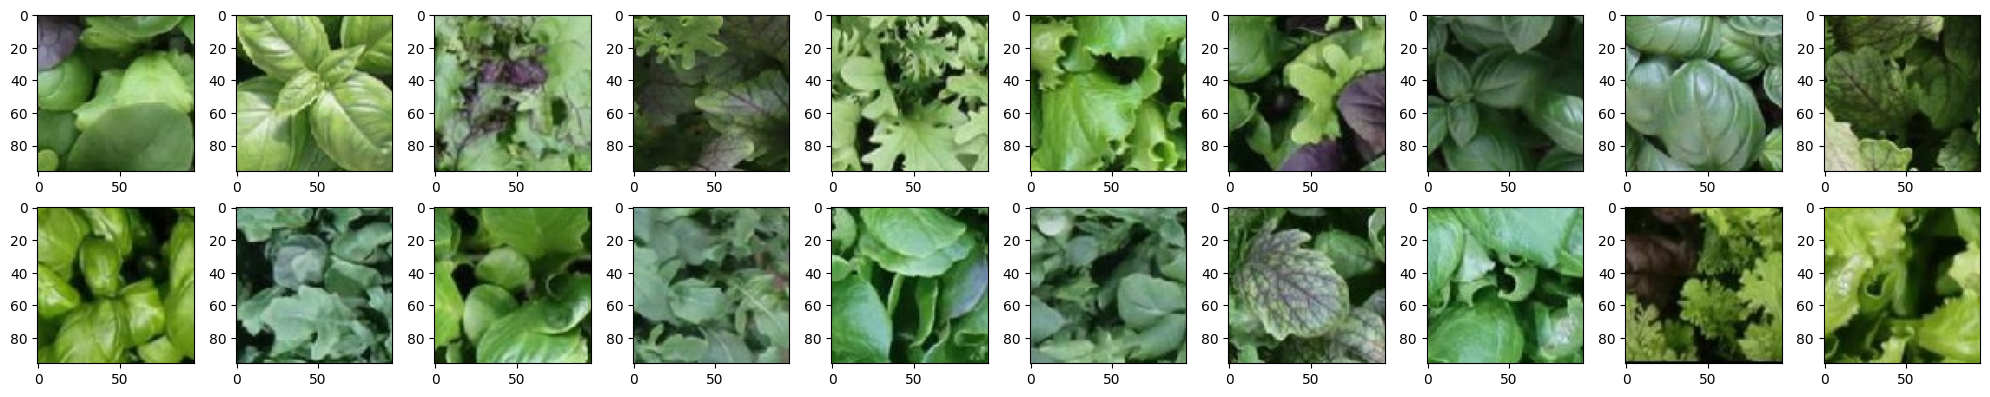

In [ ]:
num_img=10

fig, axes = plt.subplots(2, num_img, figsize=(20,4))
for i in range(num_img):
    ax = axes[0,i%num_img]
    ax.imshow(x_train_h[i]/255)
    ax = axes[1,i%num_img]
    ax.imshow(np.clip(x_train_unh[i]/255, 0, 1))
plt.tight_layout()
plt.show()

In [ ]:
y_test=[]


x_test=[]

for el in obj_ts_h:
    im=cv2.cvtColor(cv2.imread(el), cv2.COLOR_BGR2RGB)
    x_test.append(im)
    y_test.append([np.float32(0)])


for el in obj_ts_un:
    im=cv2.cvtColor(cv2.imread(el), cv2.COLOR_BGR2RGB)
    x_test.append(im)
    y_test.append([np.float32(1)])


shuffle_indexes=np.arange(len(y_test))
np.random.seed=seed
np.random.shuffle(shuffle_indexes)

x_test=np.array(x_test)
y_test=np.array(y_test)


x_test=x_test[shuffle_indexes]
y_test=y_test[shuffle_indexes]


In [ ]:
print(len(x_train_h))
print(len(x_train_unh))
print(len(y_train_h))
print(len(y_train_unh))

print(x_val.shape)
print(y_val.shape)

2478
1450
2478
1450
(437, 96, 96, 3)
(437, 1)


In [ ]:
x_train.shape , y_train.shape  ,  x_val.shape  ,  y_val.shape


((3928, 96, 96, 3), (3928, 1), (437, 96, 96, 3), (437, 1))

# DATA AUGMENTATION


In [ ]:
# one-hot-encoding of y_val and y_test
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

#### MIXUP function: given two images and their labels, return a mixup version of them

In [ ]:
def mixup_im(train_ds_one , train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = 0.4
    beta = 0.4

    # Get a sample from the Beta distribution
    lambda_value = np.random.beta(alpha, beta,1)



    image=image1*lambda_value+image2*(1-lambda_value)
    labelA = label1[0] * lambda_value + label2[0] * (1 - lambda_value)
    labelB = label1[1] * lambda_value + label2[1] * (1 - lambda_value)
    label=np.array([labelA[0],labelB[0]])

    return image,label


### Random_OverSampler

- generate by SMOTE $n\_h$ new healthy images
- generate by SMOTE as many unhealthy images in order to balance the number of healthy and unhealthy
- generate $n\_mix$ new images using mixup between the two classes


##### return two numpy arrays: X_train, Y_train

In [ ]:
def Random_OverSampler( X_h,Y_h , X_unh , Y_unh , n_h=3000 , n_mix=4000):



        x_h=[]
        y_h=[]
        x_unh=[]
        y_unh=[]



        x_mix=[]
        y_mix=[]

        len_h=len(X_h)
        len_unh=len(X_unh)

        h_indexes=np.arange(len_h)
        un_indexes=np.arange(len_unh)


        # Mixup intraclass H
        for i in range(n_h):
            idx1,idx2=np.random.choice(h_indexes , 2 , replace=False)


            im1=X_h[idx1]

            lbel1=Y_h[idx1]


            im2=X_h[idx2]
            lbel2=Y_h[idx2]

            im,lab=mixup_im((im1,lbel1) , (im2 , lbel2))

            x_h.append(im)


            y_h.append(lab)



        # Mixup intraclass UNH

        n_unh=len_h+n_h-len_unh

        for i in range(n_unh):
            idx1,idx2=np.random.choice(un_indexes , 2 , replace=False)

            im1=X_unh[idx1]
            lbel1=Y_unh[idx1]


            im2=X_unh[idx2]
            lbel2=Y_unh[idx2]

            im,lab=mixup_im((im1,lbel1) , (im2 , lbel2))

            x_unh.append(im)

            y_unh.append(lab)



        # Mixup interclass


        for i in range(n_mix):
            idx1=np.random.choice(h_indexes , 1 )[0]
            idx2=np.random.choice(un_indexes,1)[0]


            im1=X_h[idx1]
            lbel1=Y_h[idx1]


            im2=X_unh[idx2]
            lbel2=Y_unh[idx2]


            im,lab=mixup_im((im2 , lbel2)  ,  (im1,lbel1))

            x_mix.append(im)

            y_mix.append(lab)




        print("X_h", len(X_h),len(X_h[0]),type(X_h) , type(X_h[0]))
        print("X_unh", len(X_unh),len(X_unh[0]),  type(X_unh),type(X_unh[0]))
        print("x_h", len(x_h),len(x_h[0]) , type(x_h),type(x_h[0]))
        print("x_unh", len(x_unh),len(x_unh[0]), type(x_unh),type(x_unh[0]))
        print("x_mix",len(x_mix),len(x_mix[0]) , type(x_mix),type(x_mix[0]))

        X=X_h+X_unh+x_h+x_unh+x_mix
        Y=Y_h+Y_unh+y_h+y_unh+y_mix

        X=np.array(X)
        Y=np.array(Y)




        return X,Y



















In [ ]:
x_tr,Y_tr=Random_OverSampler(x_train_h ,y_train_h , x_train_unh , y_train_unh  ,n_h=1 ,n_mix=1000)

X_h 2478 96 <class 'list'> <class 'numpy.ndarray'>
X_unh 1450 96 <class 'list'> <class 'numpy.ndarray'>
x_h 1 96 <class 'list'> <class 'numpy.ndarray'>
x_unh 1029 96 <class 'list'> <class 'numpy.ndarray'>
x_mix 1000 96 <class 'list'> <class 'numpy.ndarray'>


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train generator with augmentation
train_image_gen  = ImageDataGenerator(
    rotation_range=20,
    brightness_range=(0.8,1.2),
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,)

train_dataset = train_image_gen.flow(x_tr,Y_tr ,batch_size=32, shuffle=True)


val_generator=ImageDataGenerator()

val_dataset = val_generator.flow(x_val,y_val ,batch_size=32, shuffle=False)



# RESNET_50


In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input

resnet50 = tfk.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)
resnet50.trainable = True


Add regularizer to each convolutional layer of the resnet

In [ ]:
regularizer = tfk.regularizers.l2(0.5)


for layer in resnet50.layers:
    if isinstance(layer, tfkl.Conv2D):
        layer.kernel_regularizer = regularizer

Learning Rate scheduler

In [ ]:
scheduler = tfk.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,  # Initial learning rate for training
    decay_steps=10000,            # Number of steps before decaying the learning rate
    decay_rate=0.9,              # Rate at which the learning rate decreases
)

lr_callback = tfk.callbacks.LearningRateScheduler(scheduler)

###### MODEL BUILDING

In [ ]:
inputs = tfk.Input(shape=(96, 96, 3))

x = preprocess_input(inputs)

x = resnet50(x)

x = tfkl.GlobalAveragePooling2D()(x)
x=tfkl.Dense(128, activation='relu' ,kernel_initializer=tfk.initializers.GlorotNormal() , kernel_regularizer= tfk.regularizers.l2(0.1))(x)

x=tfkl.Dropout(0.5)(x)


outputs = tfkl.Dense(2, activation='softmax' ,kernel_initializer=tfk.initializers.GlorotNormal() , kernel_regularizer=  tfk.regularizers.l2(0.05))(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='resnet50')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem_1  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                          

Computation of class weights ( NOTE: we are using the test data to compute the class weights just because the ratio healthy/unhealthy of the test dataset is the same of the training because of stratified split)

In [ ]:

train_image_gen  = ImageDataGenerator()

test_dataset = train_image_gen.flow_from_directory(directory=TEST_DIR,
                                                    target_size=IMG_SHAPE,
                                                   # color_mode='rgb',
                                                    classes=None,
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,

                                                    )

Found 485 images belonging to 2 classes.


In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(test_dataset.classes),
                                                  y=test_dataset.classes)

class_weights = dict(zip(np.unique(test_dataset.classes), class_weights))
class_weights

{0: 0.7924836601307189, 1: 1.3547486033519553}

Model training

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_dataset,
    epochs = 28,
    validation_data = val_dataset,
    class_weight=class_weights,
   callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True), lr_callback]

).history

Epoch 1/28
187/187 [==============================] - 54s 107ms/step - loss: 24.5396 - accuracy: 0.5423 - val_loss: 23.5411 - val_accuracy: 0.6659 - lr: 1.0000e-05
Epoch 2/28
187/187 [==============================] - 19s 101ms/step - loss: 22.9353 - accuracy: 0.6544 - val_loss: 22.0872 - val_accuracy: 0.7437 - lr: 9.9999e-06
Epoch 3/28
187/187 [==============================] - 19s 101ms/step - loss: 21.5013 - accuracy: 0.7066 - val_loss: 20.7031 - val_accuracy: 0.7757 - lr: 9.9998e-06
Epoch 4/28
187/187 [==============================] - 19s 103ms/step - loss: 20.1517 - accuracy: 0.7388 - val_loss: 19.3987 - val_accuracy: 0.8101 - lr: 9.9997e-06
Epoch 5/28
187/187 [==============================] - 19s 102ms/step - loss: 18.8367 - accuracy: 0.7773 - val_loss: 18.1475 - val_accuracy: 0.7963 - lr: 9.9996e-06
Epoch 6/28
187/187 [==============================] - 19s 100ms/step - loss: 17.6262 - accuracy: 0.7835 - val_loss: 16.9605 - val_accuracy: 0.8215 - lr: 9.9995e-06
Epoch 7/28
187/1

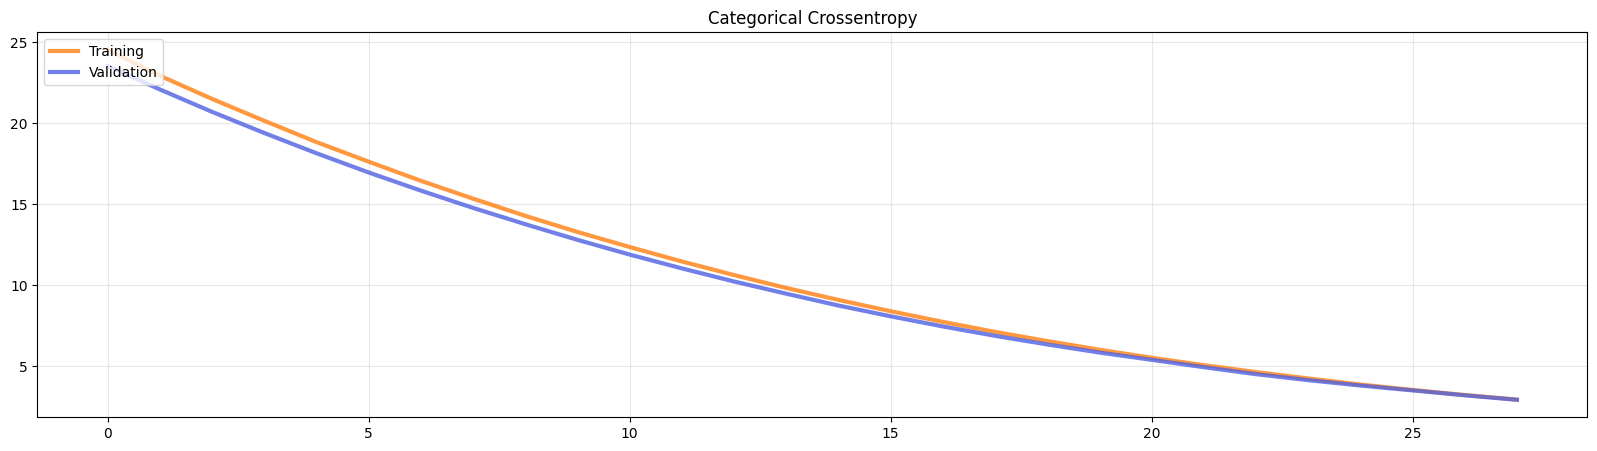

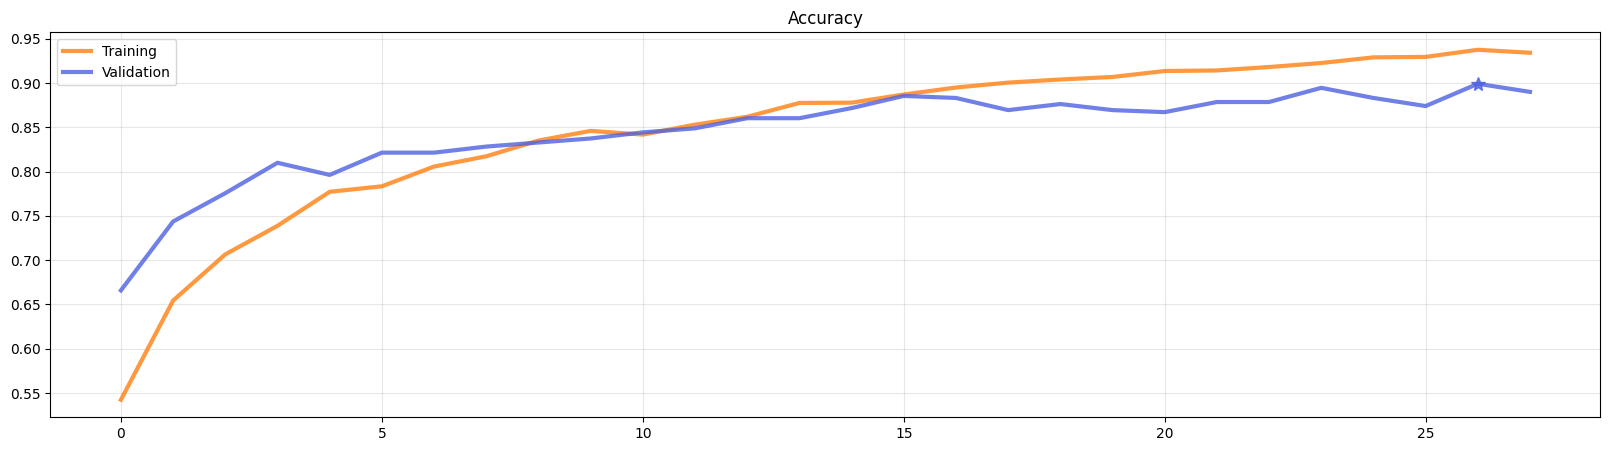

In [ ]:
# Find the epoch with the highest validation accuracy

history=tl_history
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
predictions=tl_model.predict(test_dataset)
y_pred=np.argmax(predictions, axis=1)
out = tf.convert_to_tensor(y_pred)
y_true=test_dataset.labels


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

16/16 [==============================] - 2s 34ms/step
Confusion Matrix:
[[275  31]
 [ 26 153]]
Accuracy: 0.8824742268041237
Precision: 0.8315217391304348
F1 Score: 0.8429752066115703
Recall: 0.8547486033519553


In [ ]:
tl_model.load_model('/kaggle/working/ResNet50_BALANCED_1')

## TEST TIME AUGMENTATION CHECK

In [ ]:
def TTA(model,TEST_DIR):


        test_datagen = ImageDataGenerator(
                    rotation_range=0.5,
                   # width_shift_range=0.2,
                   # height_shift_range=0.2,
                    #zoom_range=[0.5,1.2],

                    #shear_range=0.2,
                    vertical_flip=True,
                    horizontal_flip=True,
                    fill_mode='reflect')

        y_hats=[]

        n_steps=10
        BATCH=32

        for i in range(n_steps):
            preds=model.predict_generator(test_datagen.flow_from_directory(directory=TEST_DIR,
                                                              target_size=IMG_SHAPE,
                                                             # color_mode='rgb',
                                                              classes=None,
                                                              class_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,

                                                              ))
            y_hats.append(preds)

        y_hats=np.array(y_hats)
        pred=np.mean(y_hats,axis=0)
        results=np.argmax(pred,axis=1)
        #results = results.flatten()
        return results


In [ ]:
results=TTA(tl_model,TEST_DIR)
y_pred=results
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

Found 485 images belonging to 2 classes.
Found 485 images belonging to 2 classes.
Found 485 images belonging to 2 classes.
Found 485 images belonging to 2 classes.
Found 485 images belonging to 2 classes.
Found 485 images belonging to 2 classes.
Found 485 images belonging to 2 classes.
Found 485 images belonging to 2 classes.
Found 485 images belonging to 2 classes.
Found 485 images belonging to 2 classes.
Confusion Matrix:
[[277  29]
 [ 16 163]]
Accuracy: 0.9072164948453608
Precision: 0.8489583333333334
F1 Score: 0.8787061994609164
Recall: 0.9106145251396648
